# Heatmaps

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Simulate embeddings for 3 classes, 10 samples each (30 total)
num_classes = 3
samples_per_class = 3
embedding_dim = 10

# For simplicity, assign similar embeddings to same class using normal distribution
torch.manual_seed(42)
embeddings = []
for c in range(num_classes):
    class_emb = torch.randn(samples_per_class, embedding_dim) + (c)
    embeddings.append(class_emb)
embeddings = torch.vstack(embeddings)  # Shape: [30, dim]

# Normalize embeddings
embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix
cos_sim_matrix = torch.matmul(embeddings, embeddings.T).cpu().numpy()  # shape: (30, 30)

# Create class labels for axis annotation
labels = [f"C{c+1}" for c in range(num_classes) for _ in range(samples_per_class)]



ModuleNotFoundError: No module named 'seaborn'

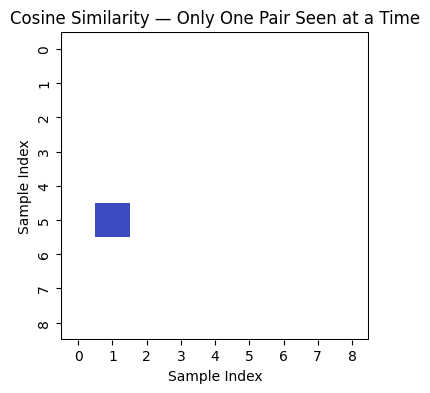

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pair_i, pair_j = 5, 1
mask = np.ones_like(cos_sim_matrix)
mask[pair_i, pair_j] = 0
# mask[pair_j, pair_i] = 0

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cos_sim_matrix, mask=mask, cmap="coolwarm", square=True, cbar=False)
plt.title("Cosine Similarity — Only One Pair Seen at a Time")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")

# Add a rectangle around the heatmap
ax.add_patch(plt.Rectangle((0, 0), len(cos_sim_matrix), len(cos_sim_matrix), fill=False, edgecolor='black', lw=1.5))

plt.show()

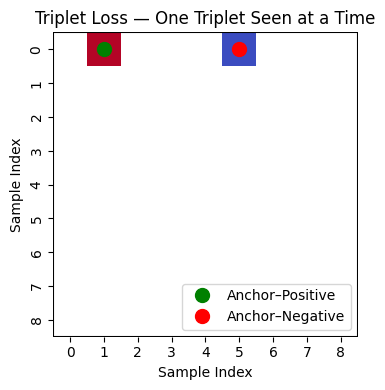

In [ ]:
anchor, positive, negative = 0, 1, 5
mask = np.ones_like(cos_sim_matrix, dtype=bool)
mask[anchor, positive] = False
# mask[positive, anchor] = False
mask[anchor, negative] = False
# mask[negative, anchor] = False

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cos_sim_matrix, mask=mask, cmap="coolwarm", square=True, cbar=False)

# Highlight the active triplet entries
ax.plot(positive + 0.5, anchor + 0.5, 'go', markersize=10, label="Anchor–Positive")  # Green
# ax.plot(anchor + 0.5, positive + 0.5, 'go', markersize=10)
ax.plot(negative + 0.5, anchor + 0.5, 'ro', markersize=10, label="Anchor–Negative")  # Red
# ax.plot(anchor + 0.5, negative + 0.5, 'ro', markersize=10)

# Rectangle around heatmap
ax.add_patch(plt.Rectangle((0, 0), cos_sim_matrix.shape[0], cos_sim_matrix.shape[1],
                           fill=False, edgecolor='black', lw=1.5))

plt.title("Triplet Loss — One Triplet Seen at a Time")
plt.legend(loc="lower right")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1868355641.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cos_sim_matrix = np.dot(embeddings, embeddings.T)


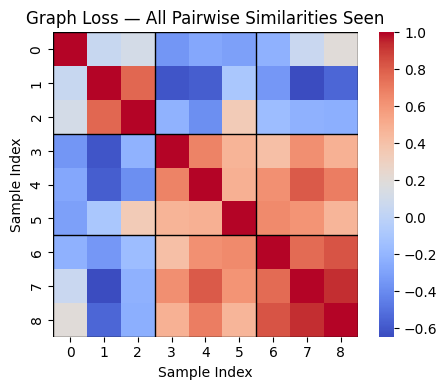

In [ ]:
cos_sim_matrix = np.dot(embeddings, embeddings.T)

# --- Plot full heatmap without masking ---
plt.figure(figsize=(5, 4))
ax = sns.heatmap(cos_sim_matrix, cmap="coolwarm", square=True, cbar=True)

# Draw grid lines to separate classes
for i in range(0, 31, samples_per_class):
    ax.axhline(i, color='black', lw=1)
    ax.axvline(i, color='black', lw=1)

plt.title("Graph Loss — All Pairwise Similarities Seen")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

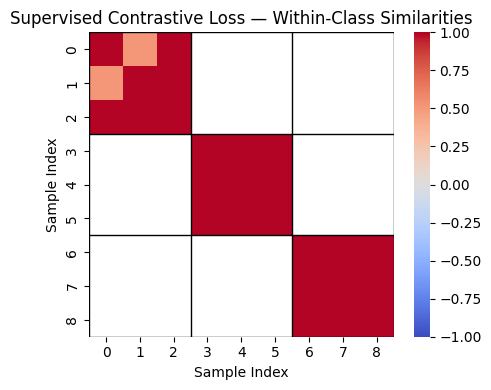

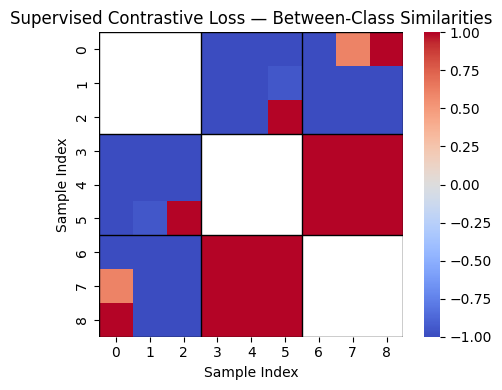

In [ ]:
# Create a mask to highlight within-class similarities
# The mask will be True for pairs within the same class and False for pairs from different classes
labels_np = np.array([c for c in range(num_classes) for _ in range(samples_per_class)])
mask_within_class = (labels_np[:, None] == labels_np[None, :])
temperature=0.1
similarity = torch.div(
    torch.matmul(embeddings, embeddings.T),
    temperature
)


plt.figure(figsize=(5, 4))
ax = sns.heatmap(similarity, mask=~mask_within_class, cmap="coolwarm", square=True, cbar=True, vmin=-1, vmax=1)

# Draw grid lines to separate classes
for i in range(0, num_classes * samples_per_class + 1, samples_per_class):
    ax.axhline(i, color='black', lw=1)
    ax.axvline(i, color='black', lw=1)

plt.title("Supervised Contrastive Loss — Within-Class Similarities")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
ax = sns.heatmap(similarity, mask=mask_within_class, cmap="coolwarm", square=True, cbar=True, vmin=-1, vmax=1)

# Draw grid lines to separate classes
for i in range(0, num_classes * samples_per_class + 1, samples_per_class):
    ax.axhline(i, color='black', lw=1)
    ax.axvline(i, color='black', lw=1)

plt.title("Supervised Contrastive Loss — Between-Class Similarities")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

# Sigma


Dataset: F1-score = 0.8102592388306674


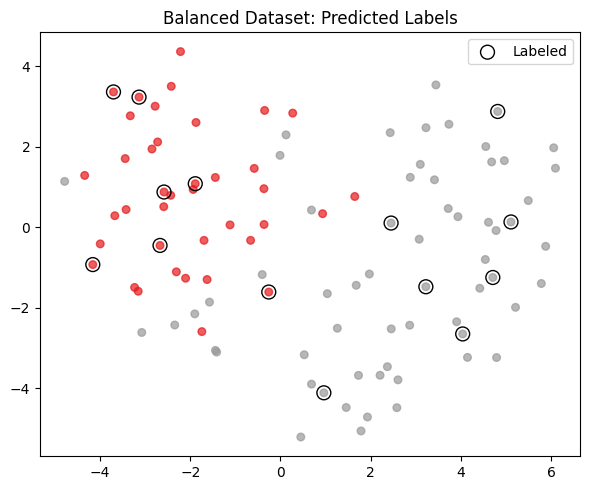

Dataset: F1-score = 0.5252653927813163


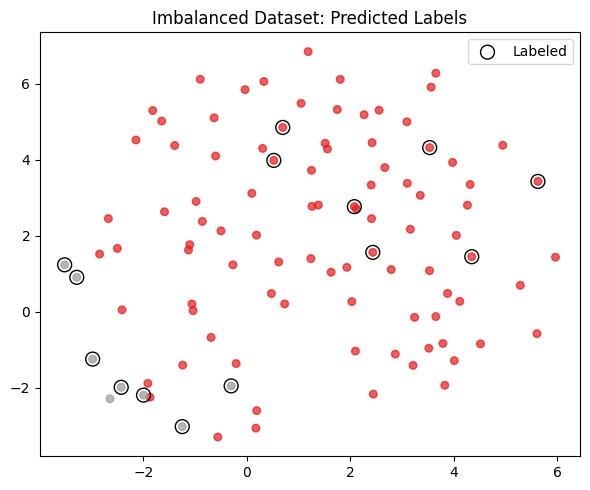

In [ ]:
import torch
import numpy as np
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, f1_score
import torch.nn.functional as F

EPS = 1e-12
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

def guassian(X):
    dist_sq = torch.cdist(X, X) ** 2
    dists_np = dist_sq.detach().cpu().numpy()
    median_sq_dist = np.median(dists_np[np.triu_indices_from(dists_np, k=1)])
    # sigma = np.sqrt(median_sq_dist/3)
    sigma = median_sq_dist
    W = torch.exp(-dist_sq / (2 * sigma ** 2))
    return W

def normalize_adj(adj):
    D = torch.sum(adj, dim=1)
    D_inv_sqrt = torch.pow(D + EPS, -0.5)
    D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.
    return D_inv_sqrt.unsqueeze(1) * adj * D_inv_sqrt.unsqueeze(0)

def lpa(train_emb, test_emb, Ytrain, num_labels):
    emb = torch.cat((train_emb, test_emb), dim=0)
    num_nodes = emb.shape[0]
    labels = torch.cat((Ytrain, torch.zeros(test_emb.shape[0], device=device)), dim=0)

    Y = torch.zeros((num_nodes, num_labels), dtype=torch.float).to(device)
    for k in range(num_labels):
        Y[labels == k, k] = 1

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:Ytrain.shape[0]] = 1
    test_mask = ~train_mask

    adj = guassian(emb)
    adj = adj + adj.t()
    adj = normalize_adj(adj)
    adj = adj.to_dense()

    F = torch.zeros_like(Y, dtype=torch.float)
    F[train_mask] = Y[train_mask]
    F[test_mask] = 0

    N_l = train_emb.shape[0]
    adj_ul = adj[N_l:, :N_l]
    adj_uu = adj[N_l:, N_l:]

    I = torch.eye(adj_uu.shape[0], dtype=torch.float)
    rhs = torch.matmul(adj_ul, F[train_mask])
    F_UU = torch.linalg.solve(I - adj_uu, rhs)

    F_UU = F_UU.real + EPS
    F_UU /= torch.sum(F_UU, axis=1, keepdims=True)
    return F_UU

def plot_results(X, y_true, pred_labels, labeled_indices, title):
    X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pred_labels, cmap='Set1', s=30, alpha=0.7)
    plt.scatter(X_2d[labeled_indices, 0], X_2d[labeled_indices, 1],
                c='none', edgecolors='black', marker='o', s=100, label='Labeled')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run on Two Datasets ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for dataset_type, weights in zip(["Balanced", "Imbalanced"], [[0.5, 0.5], [0.8, 0.2]]):
    X, y = make_classification(n_samples=100, n_features=20, n_informative=10,
                               n_redundant=0, weights=weights,
                               n_clusters_per_class=1, random_state=42)

    num_classes = len(np.unique(y))
    labeled_indices = []
    for c in range(num_classes):
        idx = np.where(y == c)[0]
        labeled_indices.extend(np.random.choice(idx, 7, replace=False))
    labeled_indices = np.array(labeled_indices)

    test_indices = np.array([i for i in range(len(y)) if i not in labeled_indices])
    Ytrain = torch.tensor(y[labeled_indices], dtype=torch.long).to(device)
    train_emb = torch.tensor(X[labeled_indices], dtype=torch.float32).to(device)
    test_emb = torch.tensor(X[test_indices], dtype=torch.float32).to(device)

    pred_soft = lpa(train_emb, test_emb, Ytrain, num_classes)
    pred_labels = pred_soft.argmax(dim=1).cpu().numpy()

    y_true_test = y[test_indices]
    full_pred = np.copy(y)
    full_pred[test_indices] = pred_labels
    print(f"Dataset: F1-score = {f1_score(y_true_test, pred_labels, average='macro')}")
    plot_results(X, y, full_pred, labeled_indices, f"{dataset_type} Dataset: Predicted Labels")

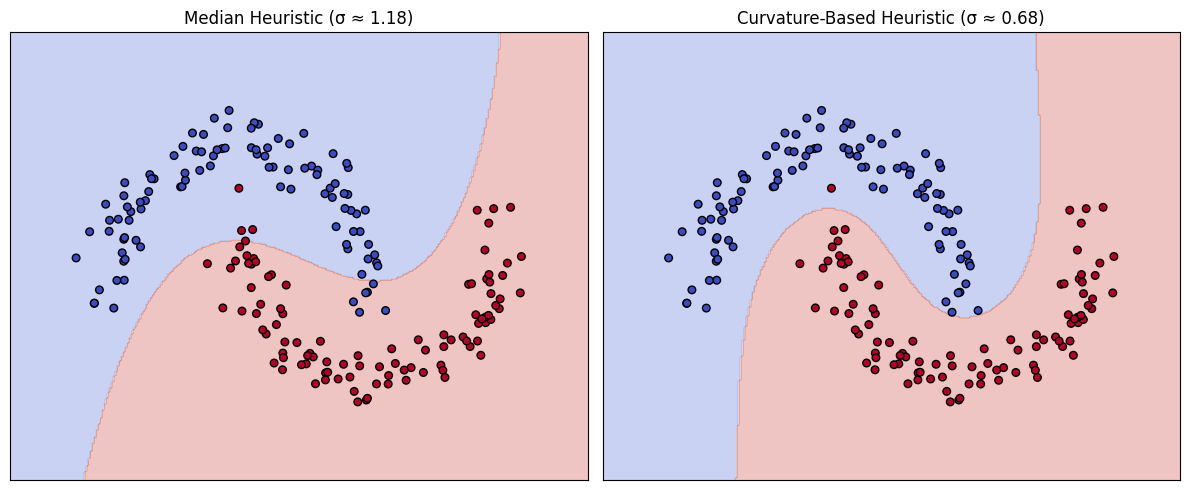

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC

# Step 1: Generate two-moon dataset
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Step 2: Compute pairwise squared distances
dists = pairwise_distances(X, metric='euclidean')
upper_tri = np.triu_indices_from(dists, k=1)
d2 = dists[upper_tri] ** 2
median_d2 = np.median(d2)
median_d = np.sqrt(median_d2)

# Step 3: Compute sigma and gamma for both heuristics

# Median Heuristic
sigma_median = median_d
gamma_median = 1 / (2 * sigma_median**2)

# Curvature-Based Heuristic
sigma_curvature = np.sqrt(median_d2 / 3)
gamma_curvature = 1 / (2 * sigma_curvature**2)

# Step 4: Train RBF SVM models
svm_median = SVC(kernel='rbf', gamma=gamma_median)
svm_curvature = SVC(kernel='rbf', gamma=gamma_curvature)
svm_median.fit(X, y)
svm_curvature.fit(X, y)

# Step 5: Function to plot decision boundary
def plot_decision_boundary(clf, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=30)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Step 6: Plot the decision boundaries
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_decision_boundary(svm_median, X, y, f"Median Heuristic (σ ≈ {sigma_median:.2f})", axs[0])
plot_decision_boundary(svm_curvature, X, y, f"Curvature-Based Heuristic (σ ≈ {sigma_curvature:.2f})", axs[1])

plt.tight_layout()
plt.show()


f1 score for median approach 0.8651685393258427
f1 score for curvature approach 0.8888888888888888


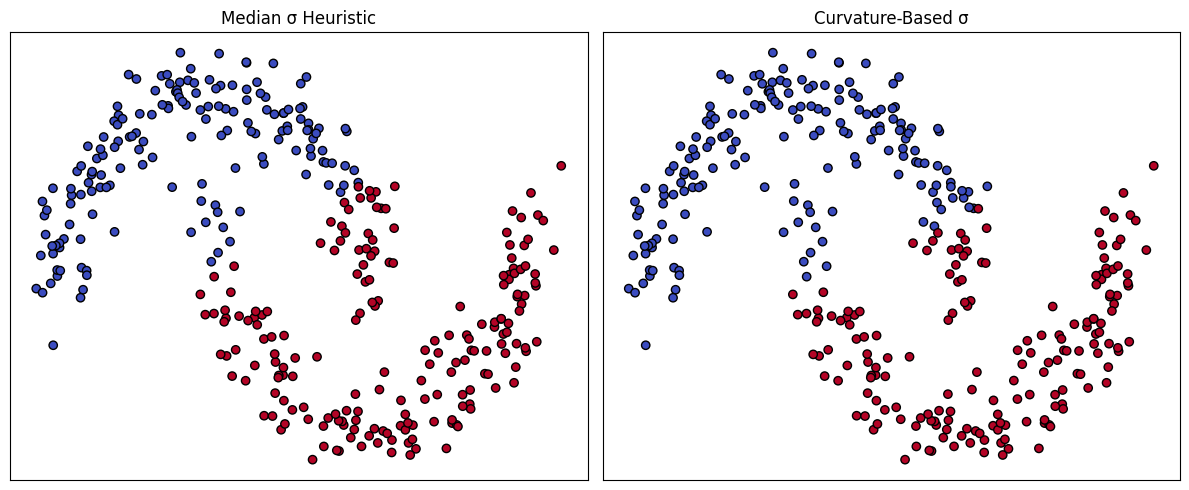

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPS = 1e-10

# Your functions
def guassian(X, use_curvature=False):
    dist_sq = torch.cdist(X, X) ** 2
    dists_np = dist_sq.detach().cpu().numpy()
    median_sq_dist = np.median(dists_np[np.triu_indices_from(dists_np, k=1)])

    if use_curvature:
        sigma = np.sqrt(median_sq_dist / 3)
    else:
        sigma = np.sqrt(median_sq_dist)

    W = torch.exp(-dist_sq / (2 * sigma ** 2))
    return W

def normalize_adj(adj):
    D = torch.sum(adj, dim=1)
    D_inv_sqrt = torch.pow(D + EPS, -0.5)
    D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.
    return D_inv_sqrt.unsqueeze(1) * adj * D_inv_sqrt.unsqueeze(0)

def lpa(train_emb, test_emb, Ytrain, num_labels, use_curvature=False):
    emb = torch.cat((train_emb, test_emb), dim=0)
    num_nodes = emb.shape[0]
    labels = torch.cat((Ytrain, torch.zeros(test_emb.shape[0], device=device)), dim=0)

    Y = torch.zeros((num_nodes, num_labels), dtype=torch.float).to(device)
    for k in range(num_labels):
        Y[labels == k, k] = 1

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:Ytrain.shape[0]] = 1
    test_mask = ~train_mask

    adj = guassian(emb, use_curvature)
    adj = adj + adj.t()
    adj = normalize_adj(adj)
    adj = adj.to_dense()

    F = torch.zeros_like(Y, dtype=torch.float)
    F[train_mask] = Y[train_mask]
    F[test_mask] = 0

    N_l = train_emb.shape[0]
    adj_ul = adj[N_l:, :N_l]
    adj_uu = adj[N_l:, N_l:]

    I = torch.eye(adj_uu.shape[0], dtype=torch.float, device=device)
    rhs = torch.matmul(adj_ul, F[train_mask])
    F_UU = torch.linalg.solve(I - adj_uu, rhs)

    F_UU = F_UU.real + EPS
    F_UU /= torch.sum(F_UU, axis=1, keepdims=True)
    return F_UU

# Prepare data
X, y = make_moons(n_samples=700, noise=0.1, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Apply LPA with both heuristics
pred_median = lpa(X_train_tensor, X_test_tensor, y_train_tensor, num_labels=2, use_curvature=False)
pred_curvature = lpa(X_train_tensor, X_test_tensor, y_train_tensor, num_labels=2, use_curvature=True)

# Convert predictions to labels
labels_median = pred_median.argmax(dim=1).cpu().numpy()
print('f1 score for median approach', f1_score(y_test, labels_median))
labels_curvature = pred_curvature.argmax(dim=1).cpu().numpy()
print("f1 score for curvature approach", f1_score(y_test, labels_curvature))

# Plotting
def plot_lpa_results(X_test, y_test, preds, title, ax):
    ax.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='coolwarm', edgecolors='k')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_lpa_results(X_test, y_test, labels_median, "Median σ Heuristic", axs[0])
plot_lpa_results(X_test, y_test, labels_curvature, "Curvature-Based σ", axs[1])
plt.tight_layout()
plt.show()


# Liu et al optimal sigma

In [ ]:
import torch

def sigma_selection_torch(X, y, method='w1'):
    """
    PyTorch version of sigmaSelection.m by Zhiliang Liu (2013).

    Args:
        X (Tensor): (N, D) feature matrix
        y (Tensor): (N,) integer class labels
        method (str): either 'w1' or 'w2'

    Returns:
        opt_sigma (float): optimal sigma
        B_bar (float)
        W_bar (float)
    """
    assert method in ['w1', 'w2'], "method must be 'w1' or 'w2'"

    X = X.float()
    y = y.long()
    X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-8)  # Z-score normalization

    classes = torch.unique(y)
    n_class = len(classes)
    n_samples = X.shape[0]
    class_sizes = torch.tensor([(y == c).sum() for c in classes], dtype=torch.float32)
    W_sum, B_sum = 0.0, 0.0

    for i in range(n_class):
        for j in range(i, n_class):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi = X[idx_i]
            Xj = X[idx_j]
            dist_sum = euclidean_matrix_sum(Xi, Xj)
            if i == j:
                W_sum += dist_sum
            else:
                B_sum += dist_sum

    nW = (class_sizes**2).sum().item()
    nB = (n_samples**2 - nW) / 2
    W_bar = W_sum / nW
    B_bar = B_sum / nB

    if W_bar >= B_bar:
        raise ValueError("W_bar >= B_bar! The method is not applicable!")

    log_ratio = torch.log(torch.tensor(B_bar / W_bar))
    if method == 'w1':
        opt_sigma = torch.sqrt((B_bar - W_bar) / (2 * log_ratio))
    else:  # method == 'w2'
        opt_sigma = torch.sqrt((B_bar - W_bar) / (4 * log_ratio))

    return opt_sigma.item()

def euclidean_matrix_sum(X, Y, block_size=1000):
    """
    Computes the sum of squared pairwise Euclidean distances between two matrices.
    """
    X = X.float()
    Y = Y.float()
    mSum = 0.0
    n1, n2 = X.shape[0], Y.shape[0]

    for i in range(0, n1, block_size):
        i_end = min(i + block_size, n1)
        Xi = X[i:i_end]
        for j in range(0, n2, block_size):
            j_end = min(j + block_size, n2)
            Yj = Y[j:j_end]
            dist = torch.cdist(Xi, Yj, p=2) ** 2
            mSum += dist.sum().item()
    return mSum


In [ ]:
# X: torch.tensor (N, D)
# y: torch.tensor (N,)
from sklearn.datasets import make_moons, load_wine, load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
# X, y = make_moons(n_samples=385, noise=0.1, random_state=0, shuffle=False)
# X, y = make_classification(n_samples=500, n_classes=3, weights=[0.7, 0.2, 0.1], n_informative=5, n_features=10, random_state=42)
X,y = load_iris(return_X_y=True)
# Convert properly to torch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()
# print(X_tensor.shape, y_tensor.shape, np.unique(y_tensor).shape[0])

opt_sigma = sigma_selection_torch(X_tensor, y_tensor, method='w1')
print(f"Optimal σ: {opt_sigma:.4f}")

Optimal σ: 1.6456


# class weighted sigma


median                 σ = 8.7491 → Macro-F1 = 0.4232
sqrt(median/3)         σ = 5.0513 → Macro-F1 = 0.1174
liu                    σ = 3.1628 → Macro-F1 = 0.3379
class_weighted_liu     σ = 6.4899 → Macro-F1 = 0.2819


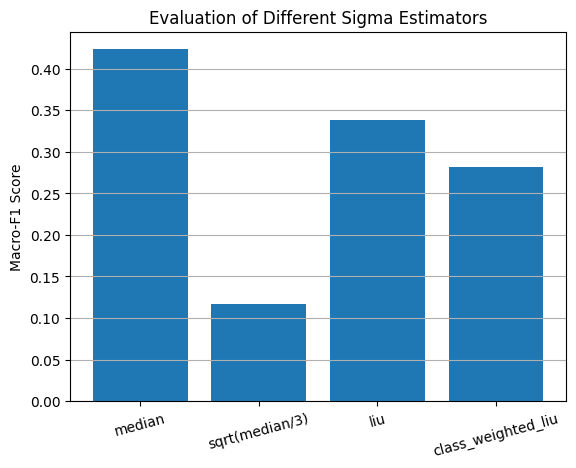

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------- Label Propagation ----------
def label_propagation(X, labeled_indices, labels_partial, sigma):
    N = X.shape[0]
    k = int(labels_partial.max().item()) + 1

    all_labels = torch.full((N,), -1, dtype=torch.long)
    for i, idx in enumerate(labeled_indices):
        all_labels[idx] = labels_partial[i]

    unlabeled_indices = [i for i in range(N) if i not in labeled_indices]

    dist_matrix = torch.cdist(X, X, p=2)
    W = torch.exp(-dist_matrix ** 2 / (2 * sigma ** 2))

    W_UL = W[unlabeled_indices][:, labeled_indices]
    W_UU = W[unlabeled_indices][:, unlabeled_indices]

    YL = torch.zeros((len(labeled_indices), k), dtype=torch.float)
    for i, idx in enumerate(labeled_indices):
        YL[i, all_labels[idx]] = 1

    I = torch.eye(W_UU.shape[0])
    YU = torch.linalg.solve(I - W_UU, W_UL @ YL)
    YU = YU / (YU.sum(dim=1, keepdim=True) + 1e-8)
    return YU.argmax(dim=1)


# ---------- Sigma Estimators ----------
def median_sigma(X):
    dists = torch.cdist(X, X, p=2)
    median_val = torch.median(dists[dists > 0])
    return median_val.item()

def sqrt_median_div_3_sigma(X):
    dists = torch.cdist(X, X, p=2)
    median_sq = torch.median(dists[dists > 0] ** 2)
    return torch.sqrt(median_sq / 3).item()

def sigma_selection_class_weighted(X, y, use_weights=True):
    classes = torch.unique(y)
    W_sum, B_sum = 0.0, 0.0
    W_weight, B_weight = 0.0, 0.0

    for i in range(len(classes)):
        for j in range(i, len(classes)):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi, Xj = X[idx_i], X[idx_j]

            if Xi.shape[0] == 0 or Xj.shape[0] == 0:
                continue

            dist_sum = (torch.cdist(Xi, Xj, p=2) ** 2).sum().item()

            if i == j:
                w = 1.0 / (Xi.shape[0] ** 2) if use_weights else 1.0
                W_sum += w * dist_sum
                W_weight += 1
            else:
                w = 1.0 / (Xi.shape[0] * Xj.shape[0]) if use_weights else 1.0
                B_sum += w * dist_sum
                B_weight += 1

    W_bar = W_sum / W_weight
    B_bar = B_sum / B_weight

    if W_bar >= B_bar:
        raise ValueError("W̄ ≥ B̄ — Liu's method not applicable.")

    W_bar_t = torch.tensor(W_bar)
    B_bar_t = torch.tensor(B_bar)
    sigma = torch.sqrt((B_bar_t - W_bar_t) / (2 * torch.log(B_bar_t / W_bar_t)))
    return sigma.item()

# ---------- Main Evaluation ----------
def run_sigma_eval():
    # Create imbalanced dataset
    X_np, y_np = make_classification(n_samples=600, n_features=10, n_classes=3,
                                     n_informative=8,weights=[0.7, 0.1, 0.2],
                                     random_state=0)
    # X_np,y_np = load_iris(return_X_y=True)
    X = torch.tensor(X_np, dtype=torch.float32).to(device)
    y = torch.tensor(y_np, dtype=torch.long).to(device)

    # Semi-supervised split
    idx = np.arange(len(X))
    idx_train, idx_test, y_train, y_test = train_test_split(
        idx, y_np, stratify=y_np, test_size=0.3, random_state=42)
    idx_train = torch.tensor(idx_train)
    y_train_torch = torch.tensor(y_train)

    results = {}

    sigma_methods = {
        "median": median_sigma,
        "sqrt(median/3)": sqrt_median_div_3_sigma,
        "liu": lambda X: sigma_selection_torch(X, y, method='w1'),
        "class_weighted_liu": lambda X: sigma_selection_class_weighted(X, y)
    }

    for name, sigma_fn in sigma_methods.items():
        try:
            sigma = sigma_fn(X)
            preds = label_propagation(X, idx_train.tolist(), y_train_torch, sigma)
            macro_f1 = f1_score(y_np[idx_test], preds.cpu().numpy(), average="macro")
            results[name] = (sigma, macro_f1)
            print(f"{name:22s} σ = {sigma:.4f} → Macro-F1 = {macro_f1:.4f}")
        except Exception as e:
            print(f"{name:22s} failed: {e}")
            results[name] = (None, 0)

    # Plot
    plt.bar(results.keys(), [v[1] for v in results.values()])
    plt.ylabel("Macro-F1 Score")
    plt.title("Evaluation of Different Sigma Estimators")
    plt.xticks(rotation=15)
    plt.grid(True, axis='y')
    plt.show()


# Run evaluation
run_sigma_eval()

In [ ]:
import torch

def euclidean_matrix_sum(X, Y, block_size=1000):
    """Compute sum of squared pairwise Euclidean distances between X and Y."""
    mSum = 0
    nX, nY = X.shape[0], Y.shape[0]
    for i in range(0, nX, block_size):
        Xi = X[i:i+block_size]
        for j in range(0, nY, block_size):
            Yj = Y[j:j+block_size]
            dist = torch.cdist(Xi, Yj, p=2) ** 2
            mSum += dist.sum().item()
    return mSum

def sigma_selection_class_weighted(X, y, method='w1'):
    """
    Computes optimal sigma using Liu's method with class size weighting.
    X: (N, d) tensor
    y: (N,) tensor of class labels
    """
    X = X.float()
    y = y.long()
    classes = torch.unique(y)
    n_class = len(classes)
    n_samples = X.shape[0]

    W_sum = 0.0
    B_sum = 0.0
    W_weight = 0.0
    B_weight = 0.0

    for i in range(n_class):
        for j in range(i, n_class):
            idx_i = (y == classes[i])
            idx_j = (y == classes[j])
            Xi = X[idx_i]
            Xj = X[idx_j]

            if Xi.shape[0] == 0 or Xj.shape[0] == 0:
                continue

            dist_sum = euclidean_matrix_sum(Xi, Xj)

            if i == j:
                w = 1.0 / (Xi.shape[0] ** 2)
                W_sum += w * dist_sum
                W_weight += 1
            else:
                w = 1.0 / (Xi.shape[0] * Xj.shape[0])
                B_sum += w * dist_sum
                B_weight += 1

    if W_weight == 0 or B_weight == 0:
        raise ValueError("Insufficient class diversity for sigma estimation.")

    W_bar = W_sum / W_weight
    B_bar = B_sum / B_weight

    if W_bar >= B_bar:
        raise ValueError("W_bar >= B_bar; Liu method not applicable.")

    B_bar_t = torch.tensor(B_bar)
    W_bar_t = torch.tensor(W_bar)
    # Liu's sigma formulas
    if method == 'w1':
        sigma = torch.sqrt((B_bar_t - W_bar_t) / (2 * torch.log(B_bar_t / W_bar_t)))
    elif method == 'w2':
        sigma = torch.sqrt((B_bar_t - W_bar_t) / (4 * torch.log(B_bar_t / W_bar_t)))
    else:
        raise ValueError("Method must be 'w1' or 'w2'")

    return sigma.item(), B_bar_t, W_bar_t


In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X_np, y_np = make_classification(n_samples=500, n_classes=3, weights=[0.7, 0.2, 0.1], n_informative=5, n_features=10, random_state=42)
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np)

sigma, B_bar, W_bar = sigma_selection_class_weighted(X, y, method='w1')
print(f"Optimal σ: {sigma:.4f}, B̄: {B_bar:.4f}, W̄: {W_bar:.4f}")


Optimal σ: 4.6980, B̄: 48.1392, W̄: 40.3741


# LPA

In [ ]:
def compute_sigma(X):
    N = X.shape[0]
    sq_dists = []
    for i in range(N):
        for j in range(i+1, N):
            sq_dists.append(np.sum((X[i] - X[j])**2))
    med_sq = np.median(sq_dists)
    sigma = np.sqrt(med_sq / 3)
    return sigma

In [ ]:
sigma = compute_sigma(X)
print(sigma)

1.3625955623979797


In [ ]:
def label_propagation(X, labeled_indices, labels_partial, sigma=None):
    N = X.shape[0]
    all_labels = np.full(N, -1)
    for i, idx in enumerate(labeled_indices):
        all_labels[idx] = labels_partial[i]

    unlabeled_indices = [i for i in range(N) if i not in labeled_indices]

    dist_matrix = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    # print(sigma)
    W = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
    D = np.diag(W.sum(axis=1))

    W_UL = W[np.ix_(unlabeled_indices, labeled_indices)]
    W_UU = W[np.ix_(unlabeled_indices, unlabeled_indices)]

    # print(D_LL)
    k = len(np.unique(labels_partial))
    YL = np.zeros((len(labeled_indices), k))
    for i, idx in enumerate(labeled_indices):
        YL[i, all_labels[idx]] = 1

    I = np.identity(W_UU.shape[0])
    YU = np.linalg.pinv(I - W_UU).dot(W_UL).dot(YL)
    y_pred = np.argmax(YU, axis = 1)
    return y_pred

In [ ]:
all_indices = np.arange(len(X))
XL,XU, YL,YU, idx_L, idx_U = train_test_split(X, y,all_indices, test_size=0.3, random_state=42)


In [ ]:
from sklearn.metrics import f1_score
YU_pred = label_propagation(X, idx_L, YL,sigma)
print("F1 Score is:",f1_score(YU, YU_pred, average='macro'))

F1 Score is: 0.3625420292086959
